In [1]:
%load_ext autoreload
%autoreload 2
from ambiguous.dataset.dataset import DatasetFromNPY, DatasetTriplet, partition_dataset, partition_datasetV2
from ambiguous.models.cvae import ConvolutionalVAE
from ambiguous.models.readout import Readout
from ambiguous.train.train_MNIST_final_ccvae import reconstruct, reconstruct_amb, get_mu
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
SCRATCH='/network/scratch/n/nizar.islah'
mnist_og_root = SCRATCH + '/torchvision/'
emnist_og_root = SCRATCH + '/EMNIST'
emnist_root = f'{SCRATCH}/aemnistV4/'
mnist_root = f'{SCRATCH}/amnistV5/'
emccvae_path = f'{SCRATCH}/ccvae_emnistV4.pth'
mccvae_path = f'{SCRATCH}/ccvae_mnistV4.pth'

In [2]:
def load_og_datasets(dataset):
    if dataset == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        dataset = datasets.MNIST(root=mnist_og_root, download=True, train=True, transform=transform)
        train_set, val_set = torch.utils.data.random_split(dataset, [round(0.8*len(dataset)), round(0.2*len(dataset))])
        test_set = datasets.MNIST(root=mnist_og_root, download=True, train=False, transform=transform)
        print("Loaded MNIST")
    elif dataset == 'emnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            lambda x: x.rot90(1,[2,1]).flip(2)
        ])
        dataset = datasets.EMNIST(root=emnist_og_root, download=True, split='byclass', train=True, transform=transform)
        new_dataset = partition_dataset(dataset, range(10, 36))
        train_set, val_set = torch.utils.data.random_split(new_dataset, [round(0.8*len(new_dataset)), round(0.2*len(new_dataset))])
        test_set = datasets.EMNIST(root=emnist_og_root, download=True, split='byclass', train=False, transform=transform)
    dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
    return dataloader

def load_triplet_datasets():
    emnist_trainset = DatasetTriplet(root=emnist_root, split='train', transform=None)
    mnist_trainset = DatasetTriplet(root=mnist_root, split='train', transform=None)

    emnist = DataLoader(emnist_trainset, batch_size=16, shuffle=True)
    mnist = DataLoader(mnist_trainset, batch_size=16, shuffle=True)
    return mnist, emnist

def load_ccvae():
    emnist_ccvae = ConvolutionalVAE(latent_dim=10, n_cls=26, conditional=True)
    emnist_ccvae.load_state_dict(torch.load(emccvae_path, map_location='cuda'))
    mnist_ccvae = ConvolutionalVAE(latent_dim=10, n_cls=10, conditional=True)
    mnist_ccvae.load_state_dict(torch.load(mccvae_path, map_location='cuda'))
    mnist_ccvae.eval(); emnist_ccvae.eval()
    return mnist_ccvae, emnist_ccvae

def plot_reconstructions(images, fpath):
    fig=plt.figure(figsize=(12,12))
    plt.imshow(torchvision.utils.make_grid(images, nrow=1, normalize=True,padding=0).permute(1, 2, 0))
    plt.axis('off')
    fig.savefig(fpath)

def fill_onehot(n_cls, img_size=28, device='cuda'):
    fill = torch.zeros([n_cls, n_cls, img_size, img_size]).to(device)
    for i in range(n_cls):
        fill[i, i, :, :] = 1
    onehot = torch.zeros(n_cls, n_cls).to(device)
    onehot = onehot.scatter_(1, torch.LongTensor(range(n_cls)).view(n_cls,1).to(device), 1).view(n_cls, n_cls, 1, 1)
    onehot = nn.Upsample(scale_factor=4)(onehot)
    return fill, onehot

def reconstruct_dataloader(dataloader, model, onehot, fill, device='cuda', idx=0):
    images, labels = next(iter(dataloader))
    return reconstruct_(model, images, labels, onehot, fill)

def reconstruct_mix(model, images1, y1_label_, y2_label_, label_fill1, label_fill2, mix1=0.5, mix2=0.5, device='cuda'):
    y_label_ = y1_label_ + y2_label_
    label_fill = mix1*label_fill1 + mix2*label_fill2
    amb, _, _, _ = model((images1, label_fill, y_label_))
    return amb

def reconstruct_(ccvae, images, labels, onehot, fill):
    y_ = labels # (torch.rand(images.size(0), 1) * n_cls).type(torch.LongTensor).squeeze().to(device)
    y = onehot[y_]
    labels_fill_ = fill[labels]
    rec_x, _, _, _ = ccvae((images, labels_fill_, y))
    return rec_x, labels_fill_, y

In [3]:
mnist, emnist = load_triplet_datasets()

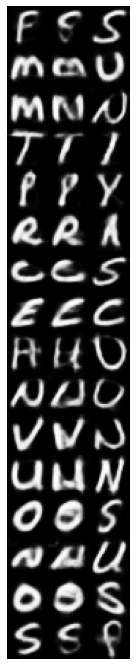

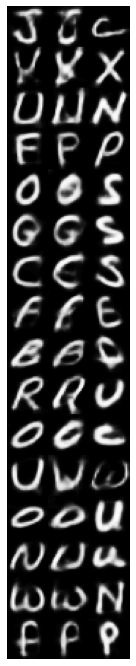

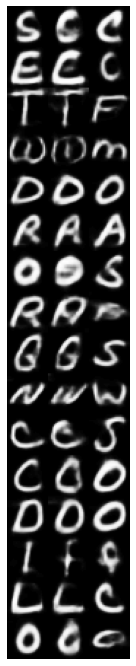

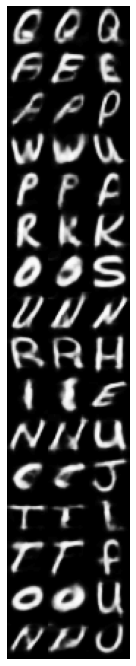

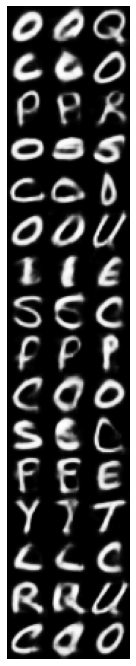

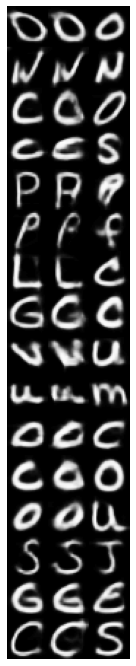

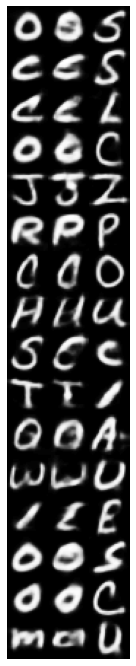

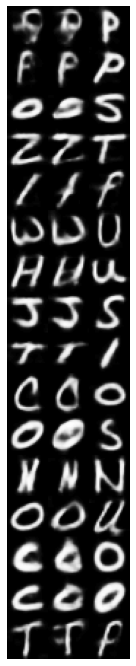

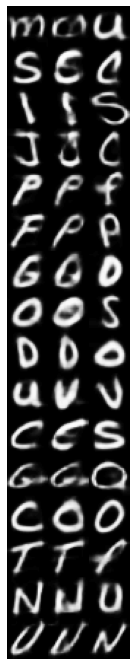

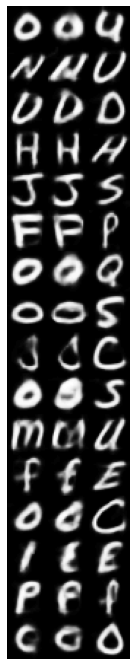

In [12]:
for i, (images, labels) in enumerate(emnist):
    if i == 10:
        break
    images = torch.cat(images, dim=-1)
    plot_reconstructions(images, f'{SCRATCH}/emnist_triplet_{i}.png')
    

In [9]:
hdim=2048
ldim=20
n_cls=26
vae = ConvolutionalVAE(ldim, n_cls=n_cls,h_dim=hdim, conditional=False,relu=True).cuda(); vae.load_state_dict(torch.load(f'{SCRATCH}/aemnistV4_checkpoints/10/vae_2048_20.pth')); vae.eval()
readout = Readout(ldim, h=hdim, n_classes=n_cls).cuda(); readout.load_state_dict(torch.load(f'{SCRATCH}/aemnistV4_checkpoints/10/readout_2048_20.pth')); readout.eval()

Readout(
  (readout): Sequential(
    (0): Linear(in_features=20, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=26, bias=True)
  )
)

IndexError: too many indices for tensor of dimension 1

In [64]:
topk

tensor([9.5908e-01, 4.0898e-02, 8.5926e-01, 8.9835e-02, 9.7118e-01, 2.8188e-02,
        9.9956e-01, 3.3771e-04, 8.2590e-01, 1.1071e-01, 9.9615e-01, 2.3740e-03,
        9.9996e-01, 1.9952e-05, 5.1787e-01, 3.7657e-01, 8.0257e-01, 1.0805e-01,
        9.7557e-01, 2.0548e-02, 8.1674e-01, 1.7174e-01, 9.0533e-01, 9.3851e-02,
        9.8726e-01, 9.7869e-03, 8.6019e-01, 1.3933e-01, 9.9305e-01, 5.9854e-03,
        6.6863e-01, 3.3134e-01])

Accuracy: 0.938             Ambiguous Accuracy: 0.438
Accuracy: 1.000             Ambiguous Accuracy: 0.562
Accuracy: 1.000             Ambiguous Accuracy: 0.562
Accuracy: 1.000             Ambiguous Accuracy: 0.688
Accuracy: 1.000             Ambiguous Accuracy: 0.688
Accuracy: 1.000             Ambiguous Accuracy: 0.688
Accuracy: 1.000             Ambiguous Accuracy: 0.750
Accuracy: 1.000             Ambiguous Accuracy: 0.562
Accuracy: 1.000             Ambiguous Accuracy: 0.625
Accuracy: 1.000             Ambiguous Accuracy: 0.562
Accuracy: 1.000             Ambiguous Accuracy: 0.688


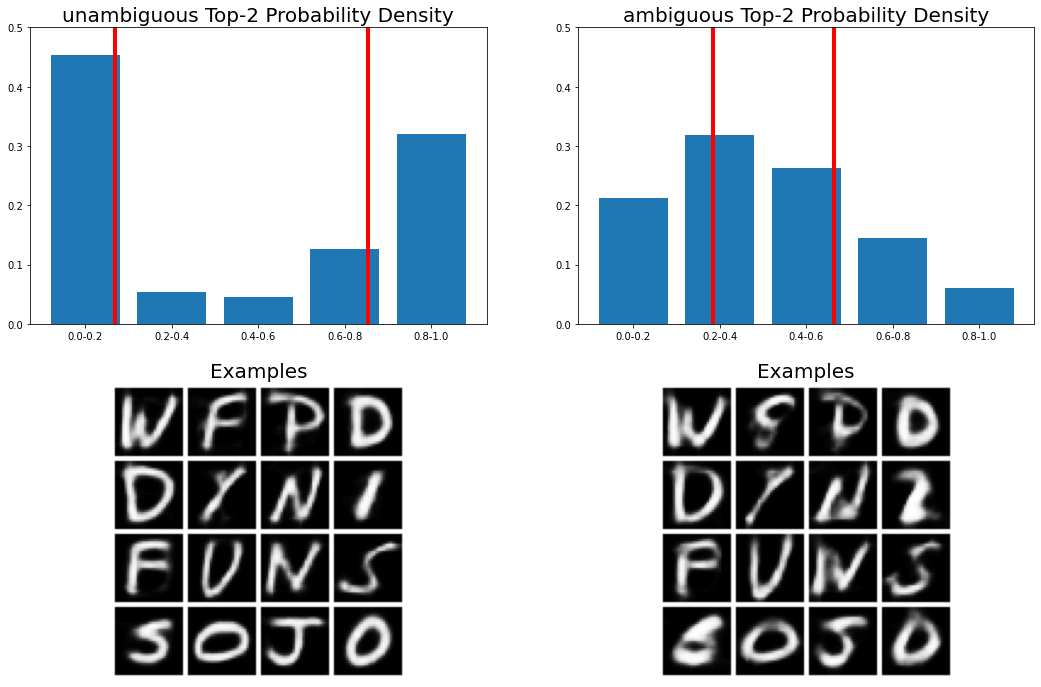

In [95]:
from ambiguous.models.readout import loss_readout
MEAN=0.5608683642727924
STD=0.07506081538822336 
def normalize(x):
    return (x - MEAN) / STD
device ='cuda'
n_batches = 50
n_examples=16
temp=3.
pred=[]
pred_amb=[]
x_unambs=[]
x_ambs=[]
for i, ((x_clean0, x_amb, x_clean1), t) in enumerate(emnist):
    images,labels = normalize(x_clean0).to(device).float(), t[:,0].to(device)
    amb = normalize(x_amb).to(device).float()
    _, preds = loss_readout(readout, vae, images, labels)
    _, pred_ambs = loss_readout(readout,vae, amb, labels)
    pred.append(preds)
    pred_amb.append(pred_ambs)
    x_unambs.append(x_clean0)
    x_ambs.append(x_amb)
    if i % 5 == 0:
        print(f"Accuracy: {preds.argmax(1).eq(labels).sum().item()/labels.size(0):.3f} \
            Ambiguous Accuracy: {pred_ambs.argmax(1).eq(labels).sum().item()/labels.size(0):.3f}")
    if i == n_batches:
        break

pred = torch.cat(pred, dim=0)
pred_amb = torch.cat(pred_amb, dim=0)
x_unambs = torch.cat(x_unambs, dim=0)
x_ambs = torch.cat(x_ambs, dim=0)

fig,ax=plt.subplots(2, 2, figsize=(18, 12))
for i,preds in enumerate([pred, pred_amb]):
    preds=torch.softmax(preds/temp,1).cpu().detach()
    topk=torch.topk(preds,k=2,dim=1)[0]
    topk_mean = list(topk[:, x].mean() for x in range(topk.size(1)))
    topk=topk.flatten()
    h=torch.histc(topk, bins=5)/topk.size(0)
    ax[0,i].bar(range(h.size(0)), h)
    ax[0,i].set_ylim(0,0.5)
    ax[0,i].set_xticks(range(h.size(0)), [f'{i/h.size(0):.1f}-{(i+1)/h.size(0):.1f}' for i in range(h.size(0))])
    title = "un" if i==0 else ""
    title += "ambiguous Top-2 Probability Density"
    ax[0,i].set_title(title, fontsize=20)
    for k in range(len(topk_mean)):
        ax[0,i].axvline(topk_mean[k]*(h.size(0)-1), color='r', lw=4)
    # plot torchvision grid of examples in next row
    grid = torchvision.utils.make_grid(x_unambs[:n_examples] if i==0 else x_ambs[:n_examples], nrow=4, padding=2, pad_value=1, normalize=True)
    ax[1,i].imshow(grid.permute(1,2,0).cpu().detach().numpy())
    ax[1,i].axis('off')
    ax[1,i].set_title(f"Examples", fontsize=20)

plt.show()

In [11]:
device='cuda'
mnist = load_og_datasets('mnist') #, load_og_datasets('emnist')
class_mnist = partition_datasetV2(mnist, 10)
mnist_ccvae, emnist_ccvae = load_ccvae()
fill_mnist, onehot_mnist = fill_onehot(10)
fill_emnist, onehot_emnist = fill_onehot(26)

Loaded MNIST


KeyboardInterrupt: 

In [36]:
rec, label_fill, y_label_ = reconstruct_dataloader(class_mnist[3], mnist_ccvae, onehot_mnist, fill_mnist)
rec, label_fill, y_label_ = reconstruct_dataloader(class_mnist[5], mnist_ccvae, onehot_mnist, fill_mnist)


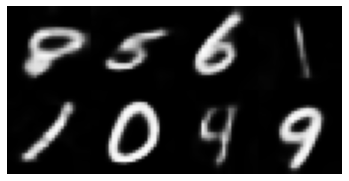

In [42]:
plot_reconstructions(rec)
